In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

# Short analysis of the biased run

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/33641000.py:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_hills = plumed.read_as_pandas("HILLS")


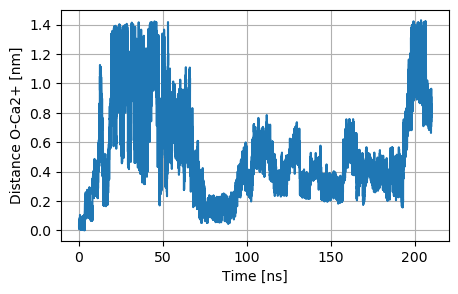

In [2]:
plt.rcParams["figure.figsize"] = (5, 3)

data_hills = plumed.read_as_pandas("HILLS")
plt.plot(data_hills["time"]*0.001, data_hills["d1"])
plt.xlabel("Time [ns]")
plt.ylabel("Distance O-Ca2+ [nm]")
plt.grid()

# Interpretation of the plots

The height must be computed with the bias at the previous step. In fact, you can write the updating law of the bias employing the insertion time as a label. A good notation should in fact be:
$$
B_{t'+\tau_G}(\{s_i(t)\}, t)=B_{t'}(\{s_i(t)\}, t)+W\exp{\left(-\frac{B_{t'}(\{s_i(t)\}, t)}{\Delta T}\right)}\exp{\left(-\sum_{i=1}^{N}\frac{(s_i(t)-s_i(t'))^2}{2\sigma_i^2}\right)}
$$

### Metadynamics bias
The increment of the bias potential at time $t>t'$: 
$$
W \exp{\left(-\frac{B_{t'}(\{s_i(t)\}, t)}{\Delta T}\right)} \exp{\left(-\sum_{i=1}^{N}\frac{(s_i(t)-s_i(t'))^2}{2\sigma_i^2}\right)}
$$
where $t'$ is a multiple of $\tau_G$. I think that this increment can go to zero when the distance $s_i(t)-s_i(t')$ is huge, namely, when the CV has deviated considerably from the value of the same CV at the time of Gaussian insertion. This difference $s_i(t)-s_i(t')$ increases when we pass from one basin to another.  This explains the drop of the bias in around 10 ns. 


## Assessment of convergence

We use the tool `sum_hills` to judge the convergence of the free energy profile as a function of the simulated time. With this command we generate many free energy files (`fes`), each one containing the estimate of the free energy up to that point in time.
```
plumed sum_hills --hills HILLS --stride 10000 --mintozero
```
We recall that in this simulation we deposited the Gaussian kernels with a `PACE=1000`. Our time step is 0.002 ps, therefore the `HILLS` file contains values sampled every 2 ps. Consequently, plumed will identify the number of deposited Gaussian kernels as 

$$ \frac{\text{Simulated time [ps]}}{ \text{Pace of deposition [ps]}}=104992$$

Therefore our previous command will generate 10 files.

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/1451123319.py:6: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/1451123319.py:6: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/1451123319.py:6: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/1451123319.py:6: UserWarning: cannot load PLUMED instance, conversions will not be available
  data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/1451123319.py:6: UserWarning: cannot load PLUMED instance, conversions will not be avail

Text(0, 0.5, 'Free energies [kJ/mol]')

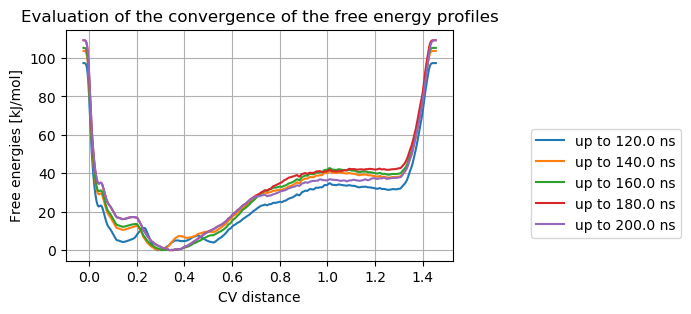

In [6]:
stride = 10000

# Plot the fes all together
for i in range(6, 11):   
    # import fes file into pandas dataset
    data=plumed.read_as_pandas("FES/fes_"+str(i)+".dat")

    plt.plot(data["d1"],data["file.free"], label="up to "+str(i  * 2 * stride/1000)+" ns")
plt.grid()
plt.title("Evaluation of the convergence of the free energy profiles")
#plt.legend(loc="best")
plt.xlabel(r"CV distance")
plt.legend(loc=[1.2, 0.1])
plt.ylabel("Free energies [kJ/mol]")

One of the great difficulties we have to face when no knowledge is provided about the free energy landscape, is that even if the system may seem to explore different regions of phase space, it can be stuck inside a single basin. This is insanely difficult to assess.

The dynamics of the CV at a certain point should be diffusive and fluctuations should become more and more important.  

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/321868175.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar = plumed.read_as_pandas("COLVAR")


Text(0, 0.5, 'Probability density')

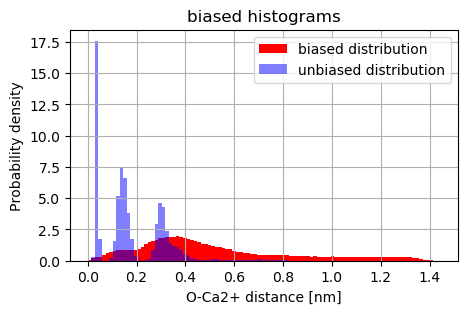

In [7]:
data_colvar = plumed.read_as_pandas("COLVAR")

val_bias, bins_bias, patches_bias = plt.hist(data_colvar["d1"], bins=100, density=True, color='r', label="biased distribution")
kT = 1
w = [math.exp(data_colvar["metad.rbias"][i])/kT for i in range(len(data_colvar["metad.rbias"]))]
#w = [math.exp(data_colvar["metad.bias"][i])/kT for i in range(len(data_colvar["metad.bias"]))]
val_unbias, bins_unbias, patches_unbias = plt.hist(data_colvar["d1"], bins=100, weights=w, density=True, alpha = 0.5, color= 'b', label="unbiased distribution")
plt.grid()
plt.legend(loc="best")
plt.title("biased histograms")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Probability density")

In [10]:
def get_fes(bins, val):
    F = []
    s = []
    kT = 1
    mesh = (bins[1] - bins[0])/2
    i = 0
    min = -kT * math.log(val[0])

    while val[i] != 0 and i<len(val)-1:
        F.append(-kT * math.log(val[i]))
        s.append(bins[i] + mesh)
        if F[i] < min:
            min = F[i]
        i = i + 1

    # Remove the offset
    F = F - min*np.ones(len(F))
    return F, s

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/435438887.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_fes = plumed.read_as_pandas("fes.dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/435438887.py:5: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_fes = plumed.read_as_pandas("fes.dat")


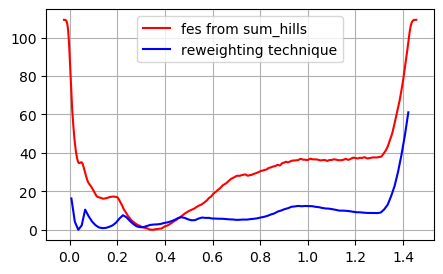

In [11]:
data_fes = plumed.read_as_pandas("fes.dat")
d1 = []
F, d1 = get_fes(bins_unbias, val_unbias)

data_fes = plumed.read_as_pandas("fes.dat")
plt.plot(data_fes["d1"],data_fes["file.free"], 'r', label="fes from sum_hills")
plt.plot(d1, F, 'b', label="reweighting technique")
plt.grid()
plt.legend(loc="best")

# Comparison with Recoverin without GRK1

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/107856445.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_fes = plumed.read_as_pandas("fes.dat")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_3171/107856445.py:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_no_GRK1 = plumed.read_as_pandas("../nmRec/fes.dat")


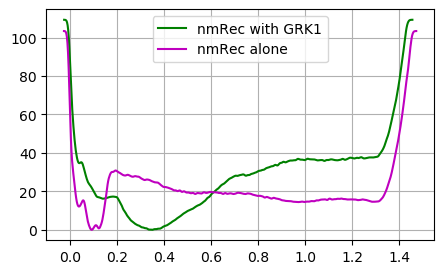

In [13]:
data_fes = plumed.read_as_pandas("fes.dat")
data_no_GRK1 = plumed.read_as_pandas("../nmRec/fes.dat")
plt.plot(data_fes["d1"],data_fes["file.free"], 'g', label="nmRec with GRK1")
plt.plot(data_no_GRK1["d1"],data_no_GRK1["file.free"], 'm', label="nmRec alone")
plt.grid()
plt.legend(loc="best")